## Segmentation of Covid+ Chest CT Scans

In [1]:
# imports

%matplotlib inline
%matplotlib notebook

import matplotlib.pyplot as plt
from math import ceil
import SimpleITK as sitk
import gui
import numpy as np
import pandas as pd
from ipywidgets import interact, fixed

### Import patient DICOM series

In [2]:
reader = sitk.ImageSeriesReader()
# import two scans from same patient at different times
dicom_names = reader.GetGDCMSeriesFileNames('./601.000000-COR 3X3-86740')
dicom_names_2 = reader.GetGDCMSeriesFileNames('./604.000000-COR 3X3-11320/')

reader.SetFileNames(dicom_names)
img1 = reader.Execute()
# used to generate an 8-bit intensity scaled series for displaying properly with segmentations
img1_255 = sitk.Cast(sitk.RescaleIntensity(img1), sitk.sitkUInt8)

reader.SetFileNames(dicom_names_2)
img2 = reader.Execute()
img2_255 = sitk.Cast(sitk.RescaleIntensity(img2), sitk.sitkUInt8)

# img_fixed = sitk.IntensityWindowing(img1, -1100, 500)

### Initial View

<IPython.core.display.Javascript object>


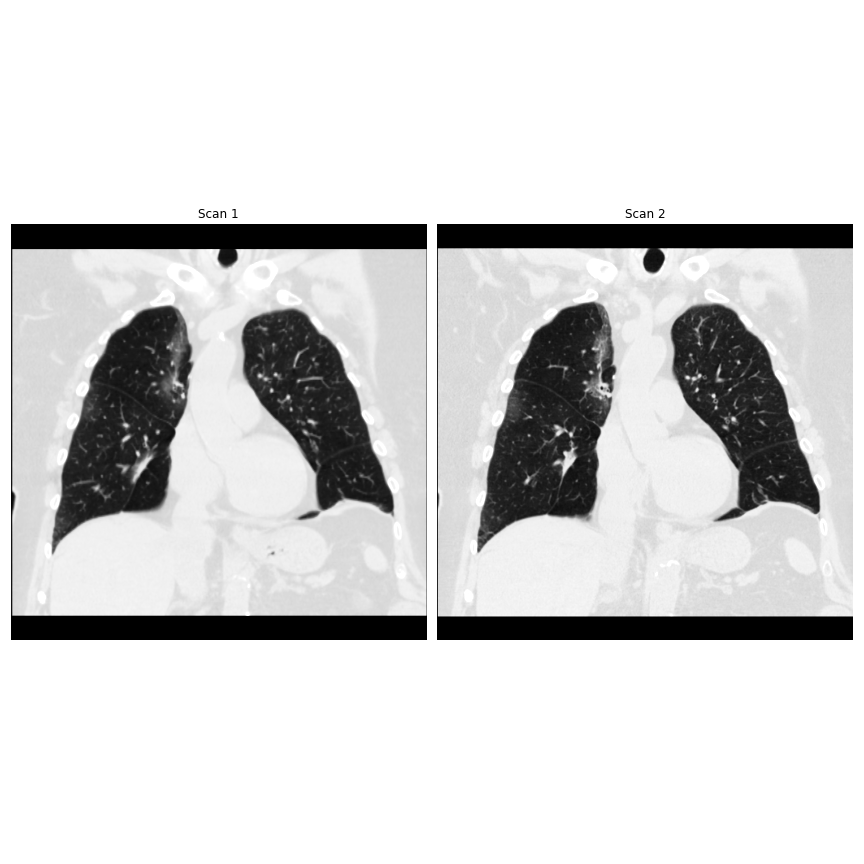

In [3]:
#common display method used throughout the project to show multiple images
gui.MultiImageDisplay(image_list=[img1, img2], title_list=['Scan 1', 'Scan 2'],
                     figure_size=(12,12))

### Histograms of scans

<IPython.core.display.Javascript object>


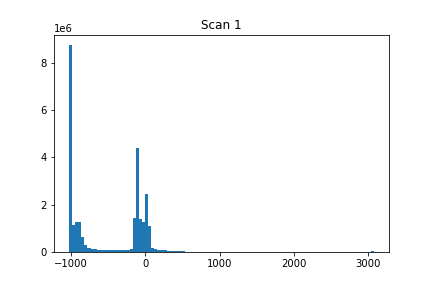

<IPython.core.display.Javascript object>


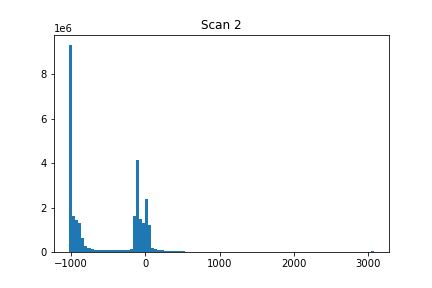

In [4]:
# generates histograms for both imported scans
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img1).flatten(), bins=100)
plt.title('Scan 1')
plt.show()

plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img2).flatten(), bins=100)
plt.title('Scan 2')
plt.show()

### Bimodal distribution suitable to apply an OTSU filter

Calculated threshold for Otsu Filter on Scan 1:  -512.0
Calculated threshold for Otsu Filter on Scan 2:  -512.0


<IPython.core.display.Javascript object>


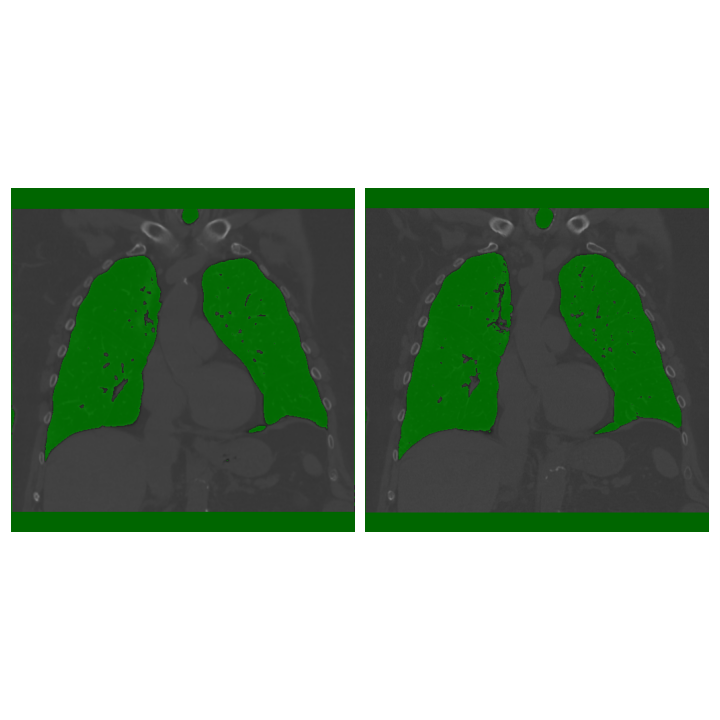

In [5]:
# while setting a manual binary threshold seg is simple given the histograms
# we have gone with an otsu filter which generated a threshold close to our 
# approximation of -500

otsu = sitk.OtsuThresholdImageFilter()
otsu.SetInsideValue(1)
otsu.SetOutsideValue(0)
seg_img_1 = otsu.Execute(img1)
print("Calculated threshold for Otsu Filter on Scan 1: ", otsu.GetThreshold())
seg_img_2 = otsu.Execute(img2)
print("Calculated threshold for Otsu Filter on Scan 2: ", otsu.GetThreshold())

gui.MultiImageDisplay(image_list=[sitk.LabelOverlay(img1_255, seg_img_1), sitk.LabelOverlay(img2_255, seg_img_2)],
                     figure_size=(10,10))

### Clean segmentations via morphological operations (opening and closing) using 10x10x10 voxel structuring elements

<IPython.core.display.Javascript object>


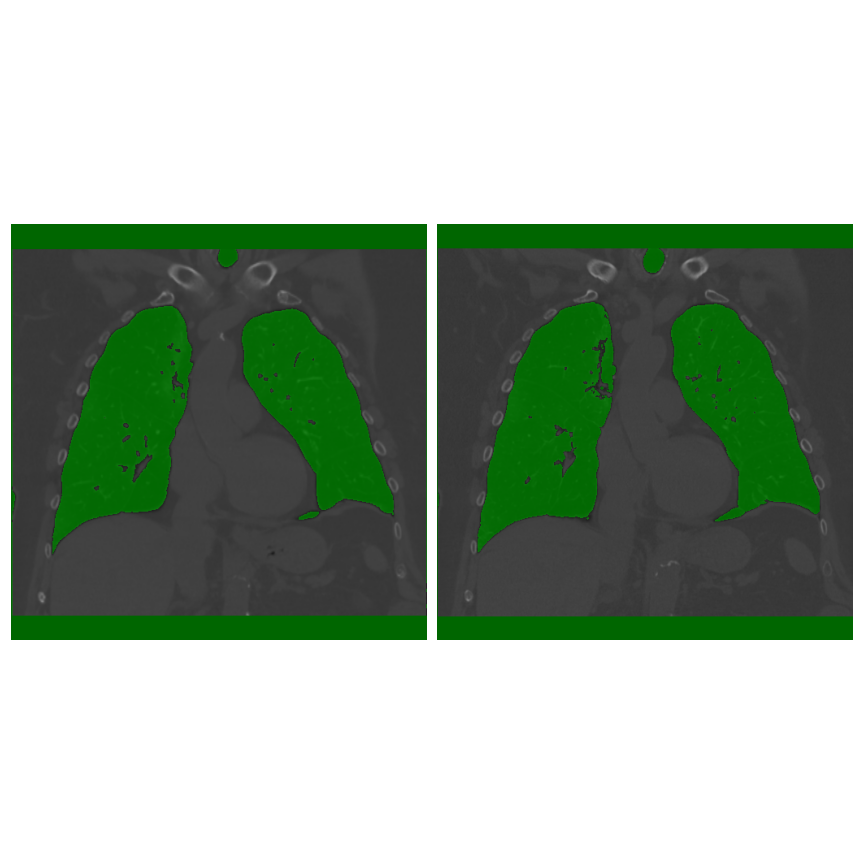

In [6]:
'''
Because of the apparent noise in some of the scans, we decided to implement
two morphological operations to connect some nearby areas and then ensure
non-touching areas are further accentuated using opening followed
by closing using a 10^3 pixel structuring element
'''
clean_seg_1 = sitk.BinaryOpeningByReconstruction(seg_img_1, [10,10,10])
clean_seg_1 = sitk.BinaryClosingByReconstruction(clean_seg_1, [10,10,10])

clean_seg_2 = sitk.BinaryOpeningByReconstruction(seg_img_2, [10,10,10])
clean_seg_2 = sitk.BinaryClosingByReconstruction(clean_seg_2, [10,10,10])

gui.MultiImageDisplay(image_list=[sitk.LabelOverlay(img1_255, clean_seg_1), sitk.LabelOverlay(img2_255, clean_seg_2)],
                     figure_size=(12,12))

### Generate a distance map of the segmentation elements using Signed Maurer Distance method from Connected Component seeds

<IPython.core.display.Javascript object>


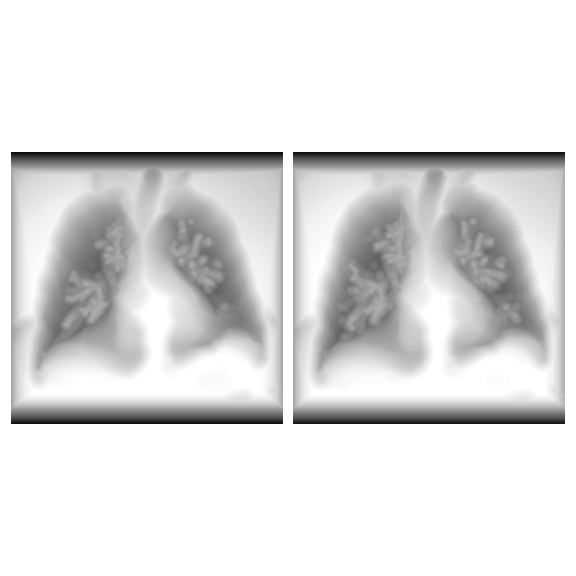

In [7]:
# using the signed maurer distance map we can establish the distance between connected
# components after the otsu filter has been cleaned up. Using signed allows for only the
# areas of interest to be considered, can be flipped using the insideIsPositive param
dist_img1 = sitk.SignedMaurerDistanceMap(clean_seg_1 != 0, insideIsPositive=False, squaredDistance=False, useImageSpacing=False)
dist_img2 = sitk.SignedMaurerDistanceMap(clean_seg_2 != 0, insideIsPositive=False, squaredDistance=False, useImageSpacing=False)

#radius to search for nearest connected components
radius = 10

seed_1 = sitk.ConnectedComponent(dist_img1 < -radius)
seed_1 = sitk.RelabelComponent(seed_1, minimumObjectSize=15)

seed_2 = sitk.ConnectedComponent(dist_img2 < -radius)
seed_2 = sitk.RelabelComponent(seed_2, minimumObjectSize=15)

gui.MultiImageDisplay(image_list=[dist_img1, dist_img2], figure_size=(8,8))

### From seeds and distance map, apply a watershed segmentation and labelling

<IPython.core.display.Javascript object>


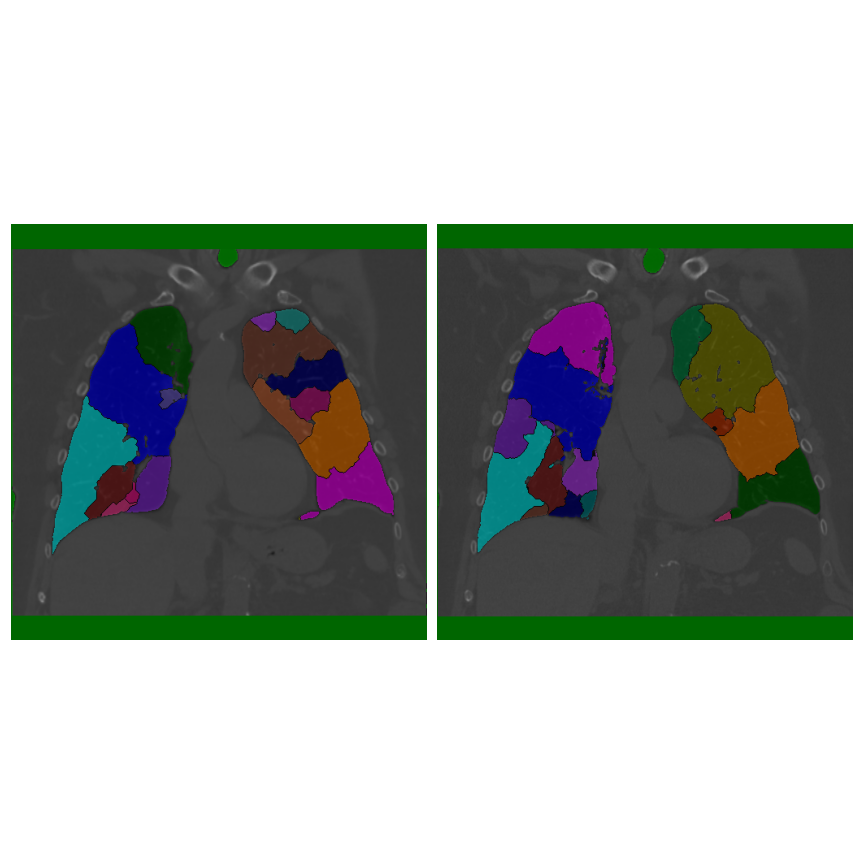

In [8]:
# using the connected component seeds and the distance map, we can apply a watershed seg
watershed_1 = sitk.MorphologicalWatershedFromMarkers(dist_img1, seed_1, markWatershedLine=True)
watershed_2 = sitk.MorphologicalWatershedFromMarkers(dist_img2, seed_2, markWatershedLine=True)

watershed_1 = sitk.Mask(watershed_1, sitk.Cast(clean_seg_1, watershed_1.GetPixelID()))
watershed_2 = sitk.Mask(watershed_2, sitk.Cast(clean_seg_2, watershed_2.GetPixelID()))

gui.MultiImageDisplay(image_list=[sitk.LabelOverlay(img1_255, watershed_1), sitk.LabelOverlay(img2_255, watershed_2)],
                     figure_size=(12,12))

### Segmentation elements touching borders irrelevant, remove those using Binary Grind Peak method

<IPython.core.display.Javascript object>


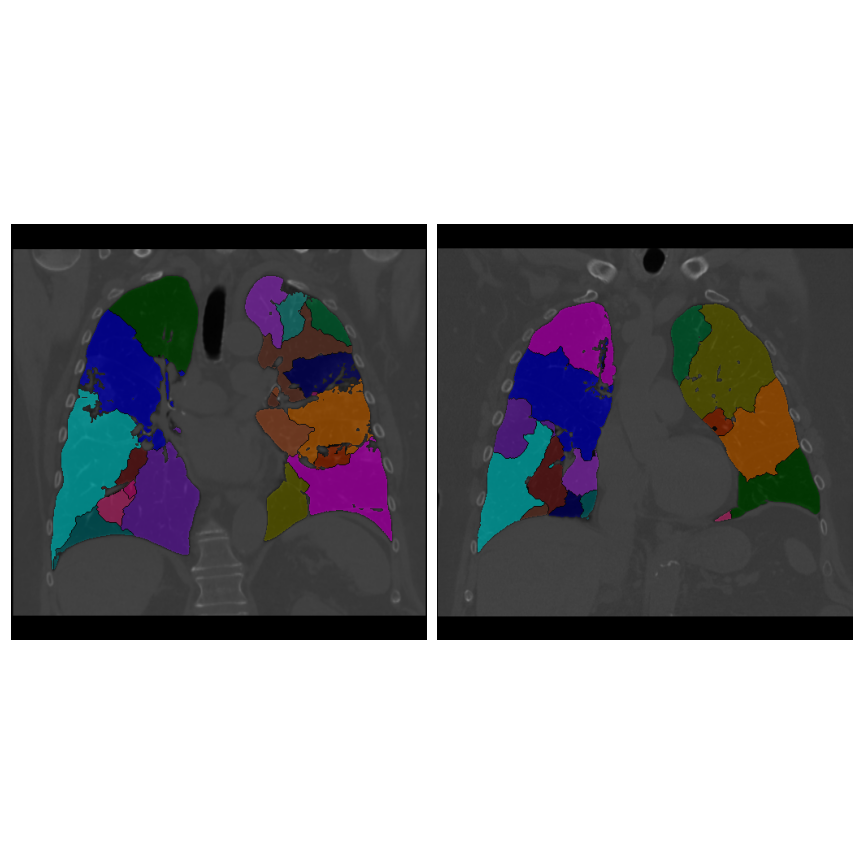

In [9]:
# the segmentations thus far have included the borders of the scan and the 
# abnormal section around the spine; using an inverted BGP filter, we can remove
# them easily to further clean up our segmentation results
bgp_1 = sitk.BinaryGrindPeak((watershed_1 != 0)| (img1==0))
no_border_seg_1 = sitk.Mask(watershed_1, bgp_1 == 0)

bgp_2 = sitk.BinaryGrindPeak((watershed_2 != 0)| (img2 ==0))
no_border_seg_2 = sitk.Mask(watershed_2, bgp_2 == 0)

gui.MultiImageDisplay(image_list=[sitk.LabelOverlay(img1_255, no_border_seg_1),
                                 sitk.LabelOverlay(img2_255, no_border_seg_2)],
                      figure_size=(12,12))

### Basic comparison of total segmented areas

Difference in means: 0.06850382415652168
Difference in max: 3.0
Difference in min: 0.0
Difference in sigmas: 0.25228096835425884


<IPython.core.display.Javascript object>


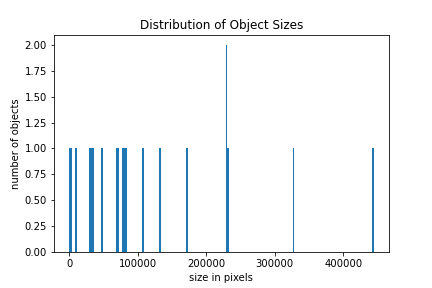

<IPython.core.display.Javascript object>


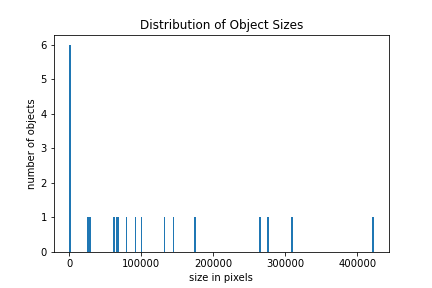

In [10]:
# using the StatisticsImageFilter for quick macro comparisons
# the values themselves may not mean much except to trained personnel
# if useful at all
try:
    img_orig = no_border_seg_1
    img_compare = no_border_seg_2
    
    sif_1 = sitk.StatisticsImageFilter()
    sif_1.Execute(img_orig)
    
    sif_2 = sitk.StatisticsImageFilter()
    sif_2.Execute(img_compare)
    
    print("Difference in means:", (sif_1.GetMean() - sif_2.GetMean()))
    print("Difference in max:", (sif_1.GetMaximum() - sif_2.GetMaximum()))
    print("Difference in min:", (sif_1.GetMinimum() - sif_2.GetMinimum()))
    print("Difference in sigmas:", (sif_1.GetSigma() - sif_2.GetSigma()))
    
    shapes = sitk.LabelShapeStatisticsImageFilter()
    shapes.Execute(sitk.ConnectedComponent(no_border_seg_1))

    label_sizes = [ shapes.GetNumberOfPixels(l) for l in shapes.GetLabels() if l != 1]

    plt.figure()
    plt.hist(label_sizes,bins=200)
    plt.title("Distribution of Object Sizes")
    plt.xlabel("size in pixels")
    plt.ylabel("number of objects")
    plt.show()
    
    shapes2 = sitk.LabelShapeStatisticsImageFilter()
    shapes2.Execute(sitk.ConnectedComponent(no_border_seg_2))

    label_sizes = [ shapes2.GetNumberOfPixels(l) for l in shapes2.GetLabels() if l != 1]

    plt.figure()
    plt.hist(label_sizes,bins=200)
    plt.title("Distribution of Object Sizes")
    plt.xlabel("size in pixels")
    plt.ylabel("number of objects")
    plt.show()
except RuntimeError as err:
    print(err)

### Find shape statistics between two scans and generate a DataFrame

In [11]:
# using pandas Dataframes we can extract useful data from the segmentations
# there are more options to add to the statistics list. This list was kept
# shorter for brevity
stat_1 = sitk.LabelShapeStatisticsImageFilter()
stat_1.ComputeOrientedBoundingBoxOn()
stat_1.Execute(no_border_seg_1)

intensity_1 = sitk.LabelIntensityStatisticsImageFilter()
intensity_1.Execute(no_border_seg_1, img1)

stat_list_1 = [(stat_1.GetPhysicalSize(i),
               stat_1.GetFlatness(i),
               intensity_1.GetMean(i),
               intensity_1.GetStandardDeviation(i),
               intensity_1.GetSkewness(i)) for i in stat_1.GetLabels()]

col = ["Volume (mm^3)", "Flatness", "Intensity Mean", "Intensity Std Dev", "Intensity Skewness"]

stats = pd.DataFrame(data = stat_list_1, index=stat_1.GetLabels(), columns = col )
stats.describe()

,Volume (mm^3),Flatness,Intensity Mean,Intensity Std Dev,Intensity Skewness
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,112718.642966,1.445400,-831.101949,89.587841,1.815191
std,99588.147589,0.215447,22.856346,8.267884,0.349413
min,3523.362766,1.184823,-871.844969,69.055166,1.183664
25%,36954.596134,1.264225,-841.513824,87.562892,1.605473
50%,69535.523490,1.421110,-835.344472,91.139758,1.743329
75%,195665.167427,1.561132,-822.629006,95.814936,1.884556
max,376670.719938,1.927220,-782.196823,98.922994,2.514826


In [12]:
stat_2 = sitk.LabelShapeStatisticsImageFilter()
stat_2.ComputeOrientedBoundingBoxOn()
stat_2.Execute(no_border_seg_2)

intensity_2 = sitk.LabelIntensityStatisticsImageFilter()
intensity_2.Execute(no_border_seg_2, img2)

stat_list_2 = [(stat_2.GetPhysicalSize(i),
               stat_2.GetFlatness(i),
               intensity_2.GetMean(i),
               intensity_2.GetStandardDeviation(i),
               intensity_2.GetSkewness(i)) for i in stat_2.GetLabels()]

cols = ["Volume (mm^3)", "Flatness", "Intensity Mean", "Intensity Std Dev", "Intensity Skewness"]

stats = pd.DataFrame(data = stat_list_2, index=stat_2.GetLabels(), columns = cols )
stats.describe()

,Volume (mm^3),Flatness,Intensity Mean,Intensity Std Dev,Intensity Skewness
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,134406.516128,1.410422,-838.615907,91.061875,1.920755
std,105184.378412,0.259450,23.103880,8.246724,0.421457
min,21863.139305,1.005619,-869.666259,79.429796,1.017061
25%,55324.984816,1.239227,-853.937835,86.099220,1.661072
50%,94345.289869,1.338688,-841.161246,90.798929,1.841672
75%,217282.955686,1.585001,-830.976088,97.382732,2.241425
max,342172.051566,1.960234,-788.890186,110.317001,2.715024


### Data visualizations

<IPython.core.display.Javascript object>


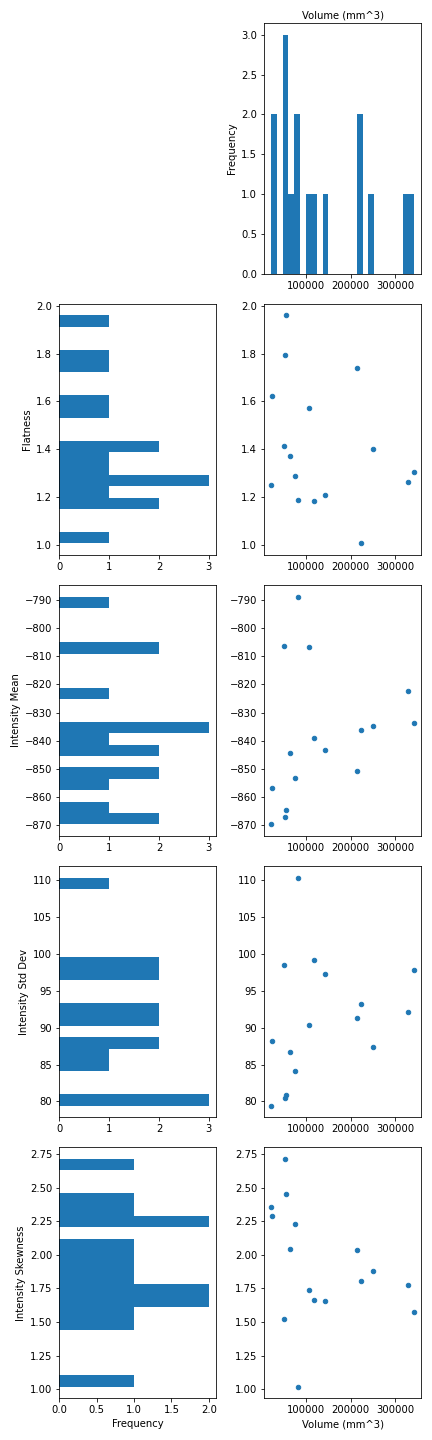

In [13]:
# applying the matplotlib features to the previous data, it is easy to visualize the data
# for quicker analysis 
fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(6,4*len(cols)))
axes[0,0].axis('off')

stats.loc[:,cols[0]].plot.hist(ax=axes[0,1], bins=25)
axes[0,1].set_xlabel(cols[0])
axes[0,1].xaxis.set_label_position("top")

for i in range(1, len(cols)):
    c = cols[i]
    bar = stats.loc[:,[c]].plot.hist(ax=axes[i,0], bins=20,orientation='horizontal',legend=False)
    bar.set_ylabel(stats.loc[:,[c]].columns.values[0])    
    scatter = stats.plot.scatter(ax=axes[i,1],y=c,x=cols[0])
    scatter.set_ylabel('')
    if(i<len(cols)-1):
        bar.set_xlabel('')
        scatter.set_xlabel('')
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()